# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: ARX

Consider a system generating observations $y_k \in \mathbb{R}$ based on inputs $u_k \in \mathbb{R}$:

$$ y_k = \theta^{\top}x_k + u_k + e_k \, ,$$

where $x_k \in \mathbb{R}^{D}$ is a vector of previous observations and $\theta$ are coefficients. The noise instances $e_k$ are assumed to be zero-mean Gaussian distributed with variance $\sigma^2$.

In [1]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("./ARXsystem.jl"); using .ARXsystem

In [2]:
# Noise
sys_mnoise_sd = 1e-1;

# True coefficients
M_in = 1
M_out = 2
M = M_in + M_out
sys_coefficients = [0.0; rand(M) .- 0.5]

4-element Vector{Float64}:
  0.0
  0.07353189317247777
  0.4541381925612361
 -0.2083661393194719

In [3]:
# Time
N = 300
Δt = 0.05
tN = range(0.0, step=Δt, length=N)

0.0:0.05:14.95

In [4]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tN) for i = 1:10]) ./ 10;

In [5]:
# Outputs

system = ARXsys(sys_coefficients, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in)

observations = zeros(N)
for k in 1:N
    ARXsystem.update!(system, controls[k])
    observations[k] = system.observation
end

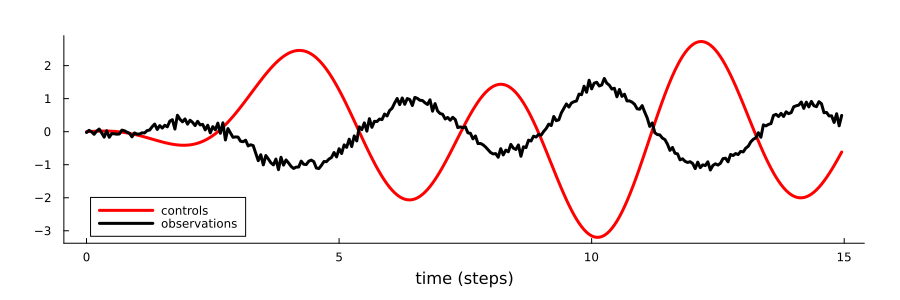

In [6]:
plot(xlabel="time (steps)", size=(900,300))
plot!(tN, controls, color="red", label="controls")
plot!(tN, observations, color="black", label="observations")

## NARX model

In [7]:
# Polynomial degree
H = 1

# Delay order
Ly = 2
Lu = 1

# Model order
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

In [8]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e-1, 1e-1)
pθ0 = MvNormalMeanCovariance(ones(M), 1e2diagm(ones(M)))

MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0]
Σ: [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 100.0 0.0; 0.0 0.0 0.0 100.0]
)


In [9]:
agent = NARXAgent(pθ0, pτ0, memory_actions=Lu, memory_senses=Ly, pol_degree=H)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0]
Σ: [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 100.0 0.0; 0.0 0.0 0.0 100.0]
)
, GammaShapeRate{Float64}(a=0.1, b=0.1), NormalMeanVariance{Float64}(μ=0.0, v=1.0), 1, 10, 1.0, 1, 2, 1, 4, [0.0, 0.0], [0.0])

## Parameter estimation

In [10]:
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(10,N)

T = 1
preds = (zeros(N,T), zeros(N,T))

@showprogress for k in 1:N
    
    # Make predictions
    preds[1][k,:], preds[2][k,:] = predictions(agent, controls[k], time_horizon=T)
    
    # Update beliefs
    NARXAgents.update!(agent, observations[k], controls[k])
    FE[:,k] = agent.free_energy
    
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


In [11]:
mθ = cat(mean.(qθ)...,dims=2)
vθ = cat( var.(qθ)...,dims=2)

4×301 Matrix{Float64}:
 100.0    0.953401    0.429142   0.2574  …  0.000194679  0.000193589
 100.0  100.0        96.3658    76.1729     0.0129591    0.0126274
 100.0  100.0       100.0       95.352      0.00854822   0.00826339
 100.0  100.0        99.9073    99.6537     0.00102392   0.00102324

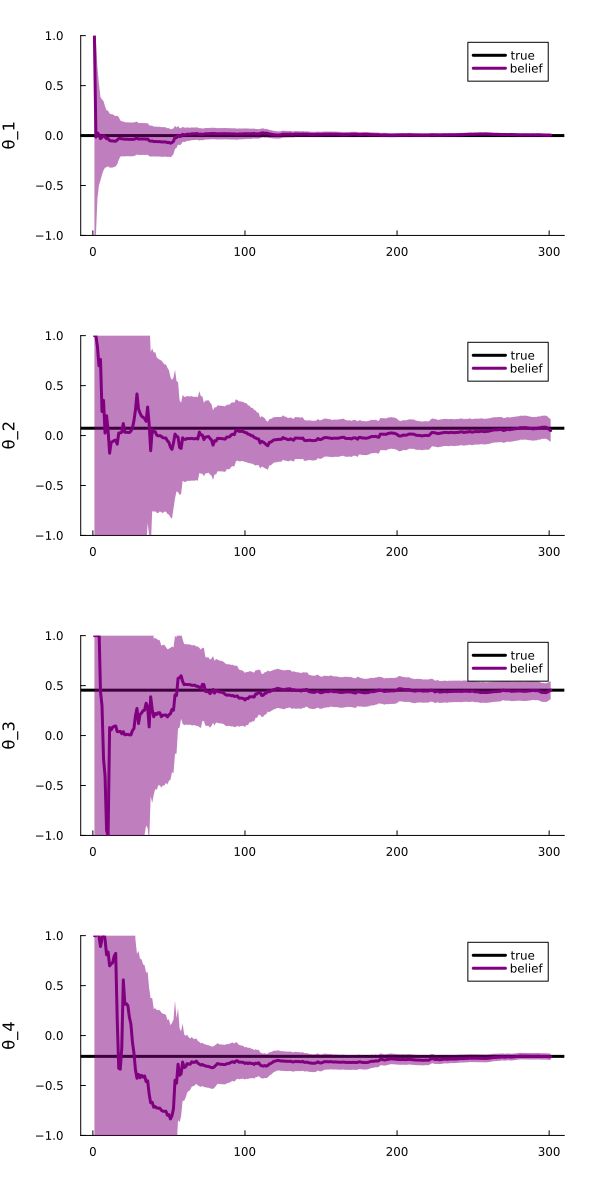

In [12]:
pw = []
for m in 1:M
    pwm = plot(ylims=(-1.,1.))
    
    hline!([sys_coefficients[m]], color="black", label="true")
    plot!(mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple", label="belief", ylabel="θ_$m")
    
    push!(pw,pwm)
end
plot(pw..., layout=(4,1), size=(600,1200))

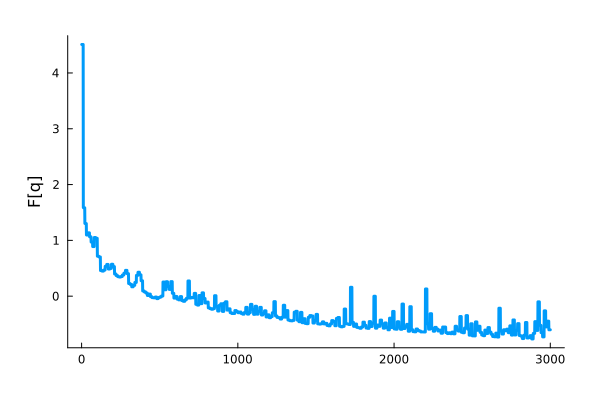

In [13]:
plot(FE[:], ylabel="F[q]")

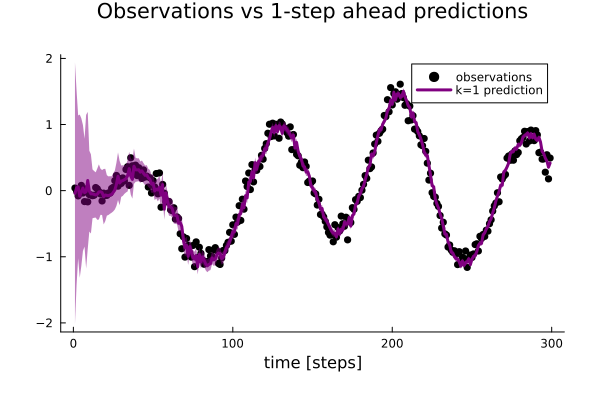

In [14]:
p1 = plot(xlabel="time [steps]", title="Observations vs 1-step ahead predictions")
scatter!(observations[2:end], color="black", label="observations")
plot!(preds[1][2:end,1], ribbon=preds[2][2:end,1], color="purple", label="k=$T prediction")

## Expected Free Energy minimization

In [15]:
# Length of trial
N = 100
tN = 1:N
T = 3;

# Set control properties
m_star = 1.0
v_star = 1e-3
goal = NormalMeanVariance(m_star,v_star)
control_prior = 1e-2
num_iters = 10

# Initialize beliefs
pτ = [pτ0]
pθ = [pθ0]

# Start system
system = ARXsys(sys_coefficients, 
                sys_mnoise_sd, 
                order_outputs=M_out, 
                order_inputs=M_in)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  memory_actions=Lu, 
                  memory_senses=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_ = zeros(N)
u_ = zeros(N+1)

pred_m = zeros(N,T)
pred_v = zeros(N,T)
FE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    ARXsystem.update!(system, u_[k])
    y_[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_[k], u_[k])
    
    FE[:,k] = agent.free_energy
    push!(pθ, agent.qθ)
    push!(pτ, agent.qτ)
    
    # Optimal control
    policy = minimizeEFE(agent)
    u_[k+1] = policy[1]
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


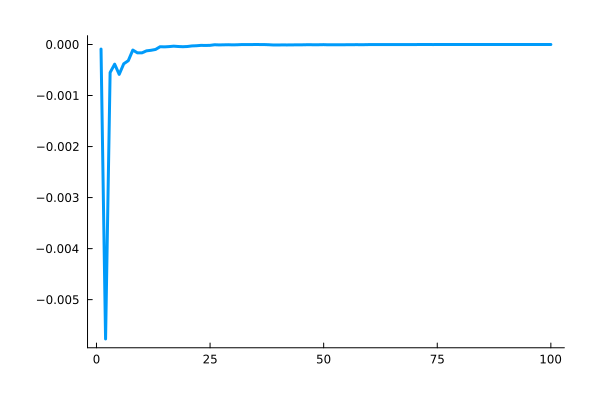

In [16]:
plot(FE[end,:] .- FE[1,:])

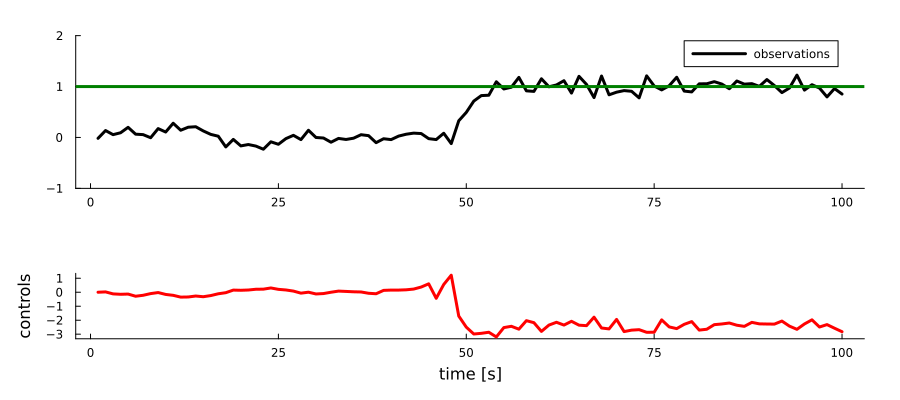

In [17]:
p1 = plot(tN, y_, color="black", label="observations")
hline!([m_star], color="green", ylims=[-1., 2.])
p4 = plot(tN, u_[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

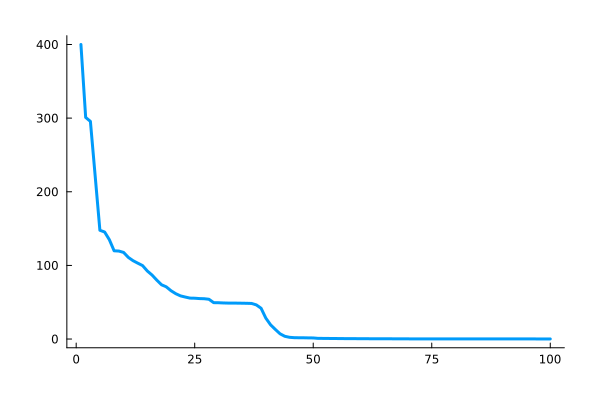

In [18]:
tSθ = [tr(cov(pθ[k])) for k in 1:N]
plot(tSθ)

[ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-EFE-verification-plan_trial00.gif


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-EFE-verification-plan_trial00.gif")
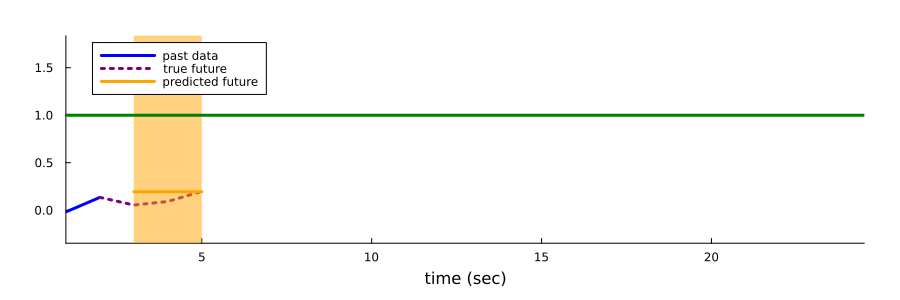

In [19]:
limsb = [minimum(y_)*1.5, maximum(y_)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tN[1:k], y_[1:k], color="blue", xlims=(tN[1], tN[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tN[k:k+T], y_[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tN[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([m_star], color="green")
    else
        plot(tN[k-window:k], y_[k-window:k], color="blue", xlims=(tN[k-window], tN[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tN[k:k+T], y_[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tN[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([m_star], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-verification-plan_trial00.gif", fps=24)